In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import rasterio as rio
from rasterio import CRS
from rasterio.transform import from_origin
from rasterio.plot import show
from rasterio.plot import show_hist
import tensorflow as tf
import keras
from keras import models, layers, utils, backend as K
import shap

from functions import preprocess, linear_regression, one_hot_encode, logistic_regression, decision_tree, binary_classification_preprocess, random_forest

In [2]:
# reads a portion of raster
def read_image_chunk(band, path, xgeo, ygeo, width, height):
    with rio.open(path) as ds:
        row, col = ds.index(xgeo, ygeo)
        data = ds.read(band,
            window=rio.windows.Window(col, row, width, height)
            )
    return data

# takes dataframe and cleans data, replacing invalid data with 0
def df_preprocess(dataframe):
    # read csv
    # reset index
    subset = dataframe
    subset = subset.reset_index(drop=True)
    # fill invalid values
    subset['dem_1'] = subset['dem_1'].replace(-9999, 0)
    subset['aspect_1'] = subset['aspect_1'].replace(255, 18)
    subset['wetlands_1'] = subset['wetlands_1'].replace(-1, 0)
    subset['wetlands_1'] = subset['wetlands_1'].replace(255, 8)
    subset['posidex_1'] = subset['posidex_1'].replace(-1, 0)
    # one hot encode categorical features
    subset = one_hot_encode(subset, "aspect_1")
    subset = one_hot_encode(subset, "wetlands_1")
    # return transformed dataframe
    print(subset.columns, subset.shape)
    return subset

def df_binary_classification_preprocess(dataframe):
    # create target 'class' column
    dataframe['class'] = dataframe.apply(lambda x: 0 if x['impervious_1'] == 0 else 1, axis=1)
    # reset index
    dataframe = dataframe.reset_index(drop=True)
    # fill invalid values
    dataframe['dem_1'] = dataframe['dem_1'].replace(-9999, dataframe['dem_1'].mean())
    dataframe['aspect_1'] = dataframe['aspect_1'].replace(255, 18)
    dataframe['wetlands_1'] = dataframe['wetlands_1'].replace(-1, 0)
    # one hot encode categorical features
    dataframe = one_hot_encode(dataframe, "aspect_1")
    dataframe = one_hot_encode(dataframe, "wetlands_1")
    return dataframe

# linear regression on a df
def df_linear_regression(df):
    dataset = df
    # define target and feature variables
    target = 'impervious_1'
    features = [
       'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
    'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
    'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
    'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
    'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
    'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
    'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
    'dem_1', 'posidex_1'
    ]
    X = dataset[features]
    y = dataset[target]
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def df_logistic_regression(dataframe):
    dataset = df_binary_classification_preprocess(dataframe)
    target = 'class'
    features = [
        'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']
    X = dataset[features]
    y = dataset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train, y_train)
    return model


In [3]:
# sequential densely connected neural network
def DNN_sequential():
    dnn = tf.keras.Sequential()
    dnn.add(tf.keras.layers.Dense(128, activation='relu'))
    dnn.add(tf.keras.layers.Dense(256, activation='relu'))   
    dnn.add(tf.keras.layers.Dense(256, activation='relu'))   
    dnn.add(tf.keras.layers.Dense(256, activation='relu'))   
    dnn.add(tf.keras.layers.Dense(128, activation='relu'))   
    dnn.add(tf.keras.layersDense(1), activation='linear')
    return dnn

# functional
def dense_block(x, nlayers, dropout=0, batch_norm=False):
    
    x = tf.keras.layers.Dense(nlayers, activation='relu')(x)
    if dropout > 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    return x

def DNN_functional(shape, out_dim, activ, norm=False):
    inputs = tf.keras.layers.Input(shape) 
    x = dense_block(inputs, 64, 0, norm)
    x = dense_block(x, 128, 0, norm)
    x = dense_block(x, 1024, 0.5, norm)
    x = dense_block(x, 256, 0.2, norm)
    output = tf.keras.layers.Dense(out_dim, activation=activ)(x)
    return tf.keras.Model(inputs=inputs, outputs=output, name='DNN')

# subclassing
class DNN_sub(tf.keras.Model):
    def __init__(self, out_dim=10, activ='softmax'):
        self.output = tf.keras.layers.Dense(out_dim, acitvation=activ)

    def dense_block(self, x, nlayers, dropout=0, batch_norm=False):
        x = tf.keras.layers.Dense(nlayers, activation='relu')(x)
        if dropout > 0:
            x = tf.keras.layers.Dropout(dropout)(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        return x

    def call(self, inputs):
        x = self.dense_block(inputs, 64, 0, True)
        x = self.dense_block(x, 128, 0, True)
        x = self.dense_block(x, 1024, 0.5, True)
        x = self.dense_block(x, 256, 0.2, True)
        return self.output(x)

def get_compiled_model(model, lr, opt, loss, metric):
    print("Compiling and returning model")
    model.summary()
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[metric]
        )
    return model

def run_training(model, tdataset, vdataset, 
                 epochs, batch_size, lr, opt, loss, metric):
    
    model = get_compiled_model(model, lr, opt, loss, metric)
    print(f"Training model")
    return model.fit(
        tdataset[0],
        tdataset[1],
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(vdataset[0], vdataset[1]),
        )


def nn_regression_preprocess(path):
    dataset = preprocess(path)
    dataset[['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1']] = dataset[['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1']] / 10000.
    dataset['NDVI'] = (dataset['landsat_4'] - dataset['landsat_3']) / (dataset['landsat_4'] + dataset['landsat_3'])
    dataset['posidex_1'] = dataset['posidex_1'] / 100.
    return dataset

def df_nn_regression_preprocess(df):
    dataset = df_preprocess(df)
    dataset[['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1']] = dataset[['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'dem_1']] / 10000.
    dataset['NDVI'] = (dataset['landsat_4'] - dataset['landsat_3']) / (dataset['landsat_4'] + dataset['landsat_3'])
    dataset['posidex_1'] = dataset['posidex_1'] / 100.
    return dataset

In [4]:
from functions import neural_net

In [5]:
# reads all files and adds each band/window of 200x200 to images array
paths = ['data/geoKARMA_h24v13_aspect_2019.tif',
         'data/geoKARMA_h24v13_dem_2019.tif',
         'data/geoKARMA_h24v13_posidex_2019.tif', 
         'data/geoKARMA_h24v13_wetlands_2019.tif',
         'data/geoKARMA_h24v13_impervious_2019.tif']
landsat = 'data/geoKARMA_h24v13_landsat_2019.tif'
landcover = 'data/geoKARMA_h24v13_landcover_2019.tif'


#opens and read paths into one array images
def open_paths():
    with rio.open(paths[0]) as src0:
        meta = src0.meta

    images = []
    with rio.open(landsat) as opened:
        count = opened.count
        for i in range(1, count+1):
            images.append(read_image_chunk(i, landsat, 1034415, 1364805, 201, 201))
    for path in paths:
        images.append(read_image_chunk(1, path, 1034415, 1364805, 201, 201))
    return meta, images

# define features based on regression model
def get_features(pred_function):
    if pred_function == linear_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1']
    if pred_function == logistic_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']
    if pred_function == decision_tree or pred_function == random_forest:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']

    if pred_function == neural_net:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1', 'NDVI']
    return features

def get_input_df(features):
    meta, images = open_paths()
    # reshapes images array into 2d array with each band as a column
    images = np.array(images).transpose().reshape(40000, 11)
    # creates dataframe from images array
    data = pd.DataFrame(images, columns = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6', 'aspect_1', 'dem_1', 'posidex_1', 'wetlands_1', 'impervious_1'])
    # data = df_preprocess(data)
    data = df_nn_regression_preprocess(data)
    df = data[features]
    return meta, df

def get_predictions(input_df, model):
    df = input_df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)
    return df

def write_raster(meta, array, new_name):
    with rio.open(new_name, 'w',
        driver='GTiff',
        dtype=np.uint16,
        width=200,
        height=200,
        count=1,
        crs=meta['crs'],
        compress='lzw',
        transform=meta['transform']) as output:
            output.write(array)

def map_impervious(pred_function, new_name):
    # define features and input
    features = get_features(pred_function)
    meta, df = get_input_df(features)

    # gets the regression model trained on full csv dataset
    print('-- Training and returning model')
    model = pred_function('./data/geoKARMA_h24v13_pixelbased_dataset.csv')
    
    #get predictions for input
    print('Applying model to get predictions')
    impervious_df = df.apply(lambda row: model.predict(row.values[None])[0], axis = 1)

    # reshapes output into 200x200 array
    impervious_output = np.array(impervious_df).reshape(1, 200, 200)
    impervious_output = np.transpose(impervious_output, (0,2,1))
    
    #write new raster
    write_raster(meta, impervious_output, new_name)
    

In [6]:
# map_impervious(linear_regression, 'new_tif_linear.tif')
map_impervious(neural_net, 'new_nntiff.tif')

Index(['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5',
       'landsat_6', 'dem_1', 'posidex_1', 'impervious_1', 'aspect_1_0',
       'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4', 'aspect_1_5',
       'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 'aspect_1_10',
       'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
       'aspect_1_15', 'aspect_1_16', 'aspect_1_17', 'aspect_1_18',
       'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4',
       'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8'],
      dtype='object') (40000, 36)
-- Training and returning model
Compiling and returning model
Model: "DNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense (Dense)               (None, 64)            

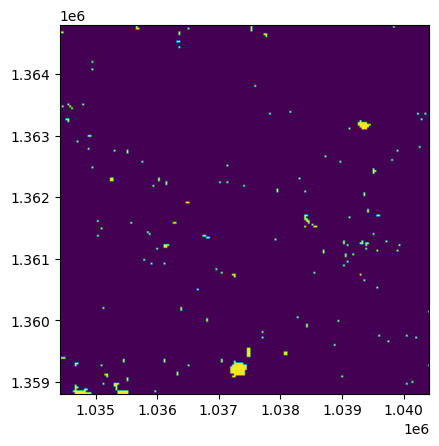

<Axes: >

In [ ]:
raster = rio.open('new_nntiff.tif')
show(raster)